In [1]:
%reset -f

import os
import numpy as np
import pandas as pd
import random
import math
from math import e

import matplotlib
import matplotlib.pyplot as plt
import configparser

In [2]:
# lectura de datos
    
def load_data():
    """Lee los datos del directorio de trabajo.
    """
    global pathoutput
    global nodos, inv, vu, cartectraf
    global HSCD, PVDT, TNTR, TAMB, PDRE, FCMX, FCPR, HVUT, AVUT
    global P1FVAC1, P1FVAC2, P1FCAR1, P1FCAR2, P1FCAR3, P1FCAR4
    global P3FVAC11, P3FVAC12, P3FVAC21, P3FVAC22, P3FVAC31, P3FVAC32
    global P3FCAR11, P3FCAR12, P3FCAR13, P3FCAR21, P3FCAR22, P3FCAR31, P3FCAR32

    pathoutput = working_dir + 'output fu/'

    ## definicion del archivo txt donde estan los parametros
    parser = configparser.ConfigParser()
    parser.read(working_dir + 'input/params.txt')

    ## parametros globales
    HSCD = float(parser['CALCULOS']['horas_sobrecarga_dia'])
    PVDT = float(parser['CALCULOS']['perdida_vida_diaria_teorica'])
    TNTR = float(parser['CALCULOS']['temperatura_normal_trafo'])
    TAMB = float(parser['CALCULOS']['temperatura_ambiente'])
    PDRE = float(parser['CALCULOS']['probabilidad_deterioro_reubicacion'])
    FCMX = float(parser['CALCULOS']['factor_carga_maxima'])
    FCPR = float(parser['CALCULOS']['factor_carga_promedio'])

    ## calculos con parametros globales
    HVUT = 24 / PVDT
    AVUT = HVUT / (24*365) 

    ##
    ## Resoluciones 818 y 819
    ##

    ##    Transformadores monofasicos - Perdidas en vacio
    ##
    P1FVAC1 = float(parser['RES818819']['P1FVAC1'])
    P1FVAC2 = float(parser['RES818819']['P1FVAC2'])

    ##
    ##    Transformadores monofasicos - Perdidas con carga
    ##        
    P1FCAR1 = float(parser['RES818819']['P1FCAR1'])
    P1FCAR2 = float(parser['RES818819']['P1FCAR2'])
    P1FCAR3 = float(parser['RES818819']['P1FCAR3'])
    P1FCAR4 = float(parser['RES818819']['P1FCAR4'])

    ##
    ##    Transformadores trifasicos -- Perdidas en vacio
    ##
    P3FVAC11 = float(parser['RES818819']['P3FVAC11'])
    P3FVAC12 = float(parser['RES818819']['P3FVAC12'])
    P3FVAC21 = float(parser['RES818819']['P3FVAC21'])
    P3FVAC22 = float(parser['RES818819']['P3FVAC22'])
    P3FVAC31 = float(parser['RES818819']['P3FVAC31'])
    P3FVAC32 = float(parser['RES818819']['P3FVAC32'])

    ##
    ##    Transformadores trifasicos - Perdidas con carga
    ##        
    P3FCAR11 = float(parser['RES818819']['P3FCAR11'])
    P3FCAR12 = float(parser['RES818819']['P3FCAR12'])
    P3FCAR13 = float(parser['RES818819']['P3FCAR13'])
    P3FCAR21 = float(parser['RES818819']['P3FCAR21'])
    P3FCAR22 = float(parser['RES818819']['P3FCAR22'])
    P3FCAR31 = float(parser['RES818819']['P3FCAR31'])
    P3FCAR32 = float(parser['RES818819']['P3FCAR32'])

    ##
    ## tablas de datos
    ##
    nodos = pd.read_csv(working_dir + "input/nodos.csv", sep=',', decimal='.')
    inv = pd.read_csv(working_dir + "input/inventario_transformadores.csv", sep=',', decimal='.')
    cartectraf = pd.read_csv(working_dir + "input/carac_tecn_transf.csv", sep=',', decimal='.')
    vu = pd.read_csv(working_dir + "input/vida_util.csv", sep=',', decimal='.')

    ##
    ## nombres de las columnas de las tablas de datos
    ##
    nodos.columns = ['id_n', 'id_n_Internexa','lat','lon','tension','cpro_n','cmax_n','cremcreg','dmda_n','cens','cred','tusu','pkwh_n']
    inv.columns = ['id_t', 'id_t_Internexa','fab','fase_t','tais','capa_t','vprim','vsecu','ffab','anus','viut_t','id_n_Internexa','tacr_t','creu_t','finst']
    vu.columns = ['tgrc', 'fase_t','lipo','lspo','cpre','dura','cpor','tmpc','tmac']
    cartectraf.columns = ['fase_t', 'capa_t','cnue_t']

    ## 
    ## adecuacion de las tablas para facilidad en calculos
    ##
    inv = inv.merge(nodos[['id_n','id_n_Internexa']], on = 'id_n_Internexa',how = 'left')

    ## calcular carga maxima y carga promedio de los nodos
    nodos['cpro_n'] = nodos['dmda_n'] / 30 * FCPR
    nodos['cmax_n'] = nodos['dmda_n'] / 30 * FCMX

    ## indicar grupo del trafo para calculo de las perdidas de transformacion
    inv['grpt_t'] = 1
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 150), 'grpt_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 800), 'grpt_t'] = 3

    ## indicar grupo del trafo para calculo de las perdidas de vida util
    inv['grpv_t'] = 1
    inv.loc[(inv.fase_t == 1) & (inv.capa_t > 50), 'grpv_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 150), 'grpv_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 500), 'grpv_t'] = 3

    ## calcular vida util restante del trafo en meses
    inv['viut_t'] = AVUT
    inv['viur_t'] = (inv.viut_t - inv.anus) * 12
    inv.loc[inv.viur_t < 0, 'viur_t'] = 1

    ## indicar grupo de vida util
    vu['grpv_t'] = 1
    vu.loc[(vu.fase_t == 1) & (vu.lipo >= 50), 'grpv_t'] = 2
    vu.loc[(vu.fase_t == 3) & (vu.lipo >= 150),'grpv_t'] = 2
    vu.loc[(vu.fase_t == 3) & (vu.lipo >= 500), 'grpv_t'] = 3

    ## armar keys para busquedas
    cartectraf['faca'] = cartectraf.fase_t.map(str) + "-" + cartectraf.capa_t.map(str)
    vu['tfcg'] = vu.tgrc.map(str) + "-" + vu.fase_t.map(str) + "-" + vu.cpre.map(str) + "-" + vu['grpv_t'].map(str)


In [3]:
# funciones core

def cospt(cmax_n,pkwh_n,capa_t,fase_t):
    faca_t = str(fase_t) + '-' + str(capa_t)
    grpt_t = 1
    if (fase_t == 3 and capa_t >= 150): grpt_t = 2
    if (fase_t == 3 and capa_t >= 800): grpt_t = 3

    futi_nt = cmax_n / capa_t

    # calcular perdidas nominales en vacio y perdidas nominales con carga en funcion de las fases y el grupo en la fase
    if fase_t == 1:
        pnvac = P1FVAC1 * capa_t ** P1FVAC2
        pncar = P1FCAR1 * capa_t ** 3 + P1FCAR2 * capa_t ** 2 + P1FCAR3 * capa_t + P1FCAR4
    else:
        if grpt_t == 1:
            pnvac = P3FVAC11 * capa_t ** P3FVAC12
            pncar = P3FCAR11 * capa_t ** 2 + P3FCAR12 * capa_t + P3FCAR13
        if grpt_t == 2:
            pnvac = P3FVAC21 * capa_t ** P3FVAC22
            pncar = P3FCAR21 * capa_t + P3FCAR22
        if grpt_t == 3:
            pnvac = P3FVAC31 * capa_t ** P3FVAC32
            pncar = P3FCAR31 * capa_t + P3FCAR32

    # calcular las perdidas en hierro y cobre en unidades W 
    pfeW = pnvac
    pcuW = pncar * futi_nt ** 2
    ptrW = pfeW + pcuW

    # monetizacion de las perdidas
    cpfe_nt = pfeW / 1000 * pkwh_n * 24 * 30
    cpcu_nt = pcuW / 1000 * pkwh_n * 24 * 30
    cpt_nt = ptrW / 1000 * pkwh_n * 24 * 30
    return (pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t)


def cosvu(cmax_n,cpro_n,capa_t,fase_t,cnue_t):
    # hallar parametros del nodo y del trafo
    grpv_t = 1
    if (fase_t == 1 and capa_t > 50): grpv_t = 2
    if (fase_t == 3 and capa_t >= 150): grpv_t = 2
    if (fase_t == 3 and capa_t >= 500): grpv_t = 3
    
    # calcular la carga precedente y el factor de utilizacion
    cpre_nt = cpro_n / capa_t
    futi_nt = cmax_n / capa_t

    # aproximar la carga precedente a los valores de la norma GTC50
    if cpre_nt < ((0.5 + 0.75) / 2):
        cpre_nt = 0.5
    else:
        if cpre_nt < ((0.75 + 0.9) / 2):
            cpre_nt = 0.75
        else:
            cpre_nt = 0.9

    # calcular el porcentaje diario de perdida de vida util real en porcentaje
    key = str(int(TAMB)) + '-' + str(fase_t) + '-' + str(cpre_nt) + '-' + str(grpv_t)
    theta = temperPC(futi_nt,key)
    fevej = (HSCD / 24) * (e**(15000/383 - 15000/(theta + 273))-1)
    pvdr = PVDT * (1 + fevej)

    # valorar perdida de vida util restante en pesos, durante lo que queda de vida util del trafo en el nodo 
    cvu_nt = cnue_t * pvdr * 30
    viur_r = 12 / (pvdr * 365)
    return (cvu_nt, viur_r)


def temperPC(futi_nt, key):
    tabvu = vu.loc[(vu.tfcg == str(key)) & (vu.dura <= HSCD)]
    ncargas = tabvu.shape[0]
    carga=futi_nt * 100
    theta=0
    if carga < tabvu['cpor'].min(): theta = TNTR
    if carga >= tabvu['cpor'].max(): theta = tabvu['tmpc'].max()
    if theta == 0:
        tabvu = tabvu.sort_values(['cpor'],ascending=[False])
        for index, row in tabvu.iterrows():
            if carga <= row['cpor']:
                theta = row['tmpc']
                break
    return theta 


def costopermtf(id_t):
    viur_t = float(inv[inv.id_t == id_t]['viur_t'])
    cperm_t = float(inv[inv.id_t == id_t]['creu_t']) / viur_t
    return cperm_t


def costodetetf(id_t):
    cnue_t = partf(id_t)[9]
    viur_t = float(inv[inv.id_t == id_t]['viur_t'])
    cdete_t = cnue_t * PDRE / viur_t
    return cdete_t

In [4]:
working_dir="../Tests/Test10/"
load_data()

#iterar
fa_t = [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
cp_t = [5,7.5,10,15,25,37.5,50,75,15,25,30,37.5,45,50,60,75,112.5,150,225,250,300,400,500]
cn_t = [1586217,1708814,1831410,2136748,2442086,2997610,3457763,4458731,2979760,3246915,3514070,3733024,3951977,4315194,4678411,5041628,5888415,7851220,11776830,13085367,15702440,20936587,26170733]


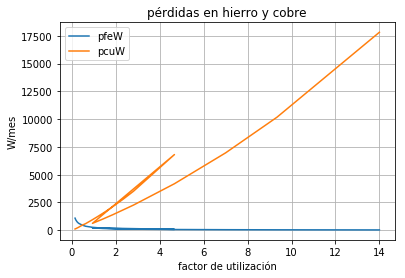

In [5]:
# ensayo 1
cmax = 70
cpro = 45
pkwh = 510

matriz = pd.DataFrame(columns=['pfeW','pcuW','ptrW','cpfe_nt','cpcu_nt','cpt_nt','futi_nt','faca_t','capa','cvu_nt','viur_r'])
for i in range (23):
    capa = cp_t[i]
    fases = fa_t[i]
    cnue = cn_t[i]
    pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t = cospt(cmax,pkwh,capa,fases)
    cvu_nt,viur_r = cosvu(cmax,cpro,capa,fases,cnue)
    matriz.loc[i]=[pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t,capa,cvu_nt, viur_r]
#matriz


df = matriz.loc[:,['pfeW','pcuW','futi_nt']]
df.set_index('futi_nt', inplace=True)
df.plot()
plt.xlabel('factor de utilización')
plt.ylabel('W/mes')
plt.title('pérdidas en hierro y cobre')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# ensayo 2
cmax = 50
cpro = 30
pkwh = 510
estres = pd.Series(range(0,210,10))
estres = estres / 100
cuenta = 0
                   
matriz = pd.DataFrame(columns=['cmax','cpro','fases','pfeW','pcuW','ptrW','cpfe_nt','cpcu_nt','cpt_nt','futi_nt','faca_t','capa','cvu_nt','viur_r'])
for i in range (23):
    capa = cp_t[i]
    fases = fa_t[i]
    cnue = cn_t[i]
    for j in range (len(estres)):
        cuenta += 1
        cmax = capa * estres[j]
        cpro = cmax * 0.4  
        pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t = cospt(cmax,pkwh,capa,fases)
        cvu_nt,viur_r = cosvu(cmax,cpro,capa,fases,cnue)
        matriz.loc[cuenta]=[cmax,cpro,fases,pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t,capa,cvu_nt, viur_r]
#matriz


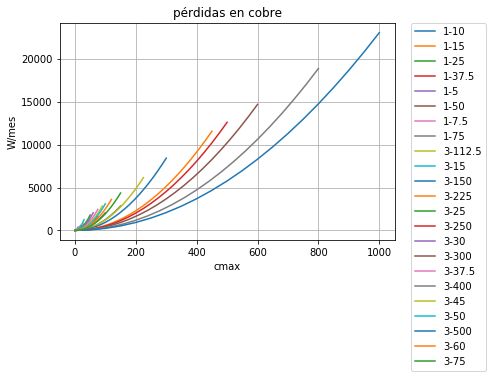

In [7]:
#perdidas en cobre
df = matriz.loc[:,['fases','cmax','faca_t','pfeW','pcuW','futi_nt','capa']]
#df = df.sort_values(['pfeW'],ascending=[True])

df.set_index('cmax', inplace=True)
a = df.groupby('faca_t')['pcuW']
print(a)
#a = a.sort_values(['faca_t'],ascending=[True])
#a = a.sort_values(['fases','capa'],ascending=[True,True])
a.plot(x='cmax')
plt.ylabel('W/mes')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




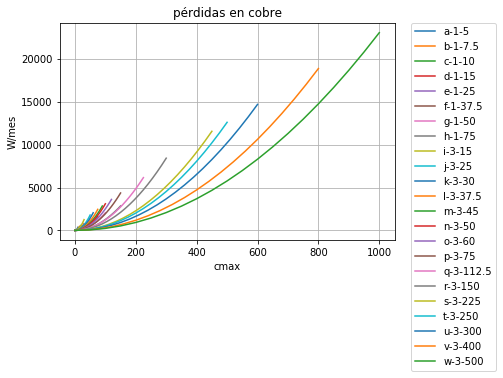

In [71]:
#reemplazar
df = matriz.loc[:,['fases','cmax','faca_t','pfeW','pcuW','futi_nt','capa']]

df.loc[(df['faca_t']=='1-5'),'faca_t'] = [['a-1-5']]
df.loc[(df['faca_t']=='1-7.5'),'faca_t'] = [['b-1-7.5']]
df.loc[(df['faca_t']=='1-10'),'faca_t'] = [['c-1-10']]
df.loc[(df['faca_t']=='1-15'),'faca_t'] = [['d-1-15']]
df.loc[(df['faca_t']=='1-25'),'faca_t'] = [['e-1-25']]
df.loc[(df['faca_t']=='1-37.5'),'faca_t'] = [['f-1-37.5']]
df.loc[(df['faca_t']=='1-50'),'faca_t'] = [['g-1-50']]
df.loc[(df['faca_t']=='1-75'),'faca_t'] = [['h-1-75']]
df.loc[(df['faca_t']=='3-15'),'faca_t'] = [['i-3-15']]
df.loc[(df['faca_t']=='3-25'),'faca_t'] = [['j-3-25']]
df.loc[(df['faca_t']=='3-30'),'faca_t'] = [['k-3-30']]
df.loc[(df['faca_t']=='3-37.5'),'faca_t'] = [['l-3-37.5']]
df.loc[(df['faca_t']=='3-45'),'faca_t'] = [['m-3-45']]
df.loc[(df['faca_t']=='3-50'),'faca_t'] = [['n-3-50']]
df.loc[(df['faca_t']=='3-60'),'faca_t'] = [['o-3-60']]
df.loc[(df['faca_t']=='3-75'),'faca_t'] = [['p-3-75']]
df.loc[(df['faca_t']=='3-112.5'),'faca_t'] = [['q-3-112.5']]
df.loc[(df['faca_t']=='3-150'),'faca_t'] = [['r-3-150']]
df.loc[(df['faca_t']=='3-225'),'faca_t'] = [['s-3-225']]
df.loc[(df['faca_t']=='3-250'),'faca_t'] = [['t-3-250']]
df.loc[(df['faca_t']=='3-300'),'faca_t'] = [['u-3-300']]
df.loc[(df['faca_t']=='3-400'),'faca_t'] = [['v-3-400']]
df.loc[(df['faca_t']=='3-500'),'faca_t'] = [['w-3-500']]

df.set_index('cmax', inplace=True)
a = df.groupby('faca_t')['pcuW']
a.plot(x='cmax')
plt.ylabel('W/mes')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




('1-5', 0.0, 0.0)
                            pcuW   cm
faca_t cmax pcuW                     
1-5    0.0  0.000000    0.000000  0.0
       0.5  0.908861    0.908861  0.5
       1.0  3.635445    3.635445  1.0
       1.5  8.179751    8.179751  1.5
       2.0  14.541780  14.541780  2.0


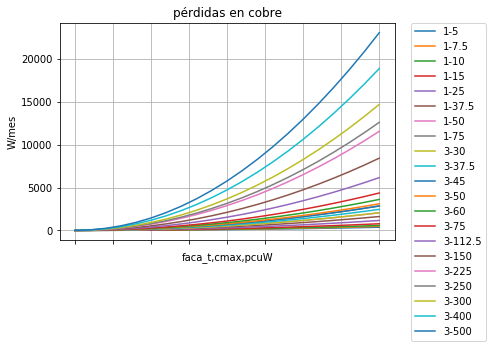

In [13]:
orden = ['1-5','1-7.5','1-10','1-15','1-25','1-37.5','1-50','1-75','3-15'',3-25','3-30','3-37.5','3-45','3-50','3-60','3-75','3-112.5','3-150','3-225','3-250','3-300','3-400','3-500']
df = matriz.loc[:,['fases','cmax','faca_t','pfeW','pcuW','futi_nt','capa']]

df.set_index('cmax', inplace=True)

grupos = df.groupby(['faca_t','cmax','pcuW'])
a = pd.DataFrame(grupos['pcuW'].sum())
a['cm'] = a.index.get_level_values('cmax')

a = a.reindex(orden, level='faca_t')
print(a.index.values[0])
print(a.head())

#a.set_index('cm', inplace=True)

b = a.groupby(['faca_t'])['pcuW']
b.plot(x='year', y='action')
plt.ylabel('W/mes')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [66]:

#perdidas en cobre
df = matriz.loc[:,['fases','cmax','faca_t','pfeW','pcuW','futi_nt','capa']]
#df = df.sort_values(['pfeW'],ascending=[True])
orden = ['1-5','1-7.5','1-10','1-15','1-25','1-37.5','1-50','1-75','3-15'',3-25','3-30','3-37.5','3-45','3-50','3-60','3-75','3-112.5','3-150','3-225','3-250','3-300','3-400','3-500']
mapping = {item: i for i, item in enumerate(orden)}
key = df['faca_t'].map(mapping)
#df = df.iloc[key.argsort()]
df.set_index('cmax', inplace=True)
a = df.groupby('faca_t').pcuW
df_pivot = a.pivot('faca_t','pcuW')

#df_grouped = df.groupby(['group', 'day']).sum().amount.reset_index()


#a = a.sort_values(['faca_t'],ascending=[True])
#a = a.sort_values(['fases','capa'],ascending=[True,True])
a.plot(x='cmax')
plt.ylabel('W/mes')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

AttributeError: 'SeriesGroupBy' object has no attribute 'pivot'

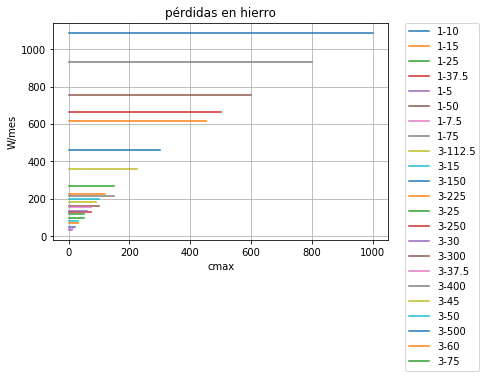

In [131]:
#perdidas en hierro
df = matriz.loc[:,['cmax','faca_t','pfeW','pcuW','futi_nt','capa']]
df.set_index('cmax', inplace=True)
a = df.groupby('faca_t')['pfeW'].plot(x='cmax')
plt.ylabel('W/mes')
plt.title('pérdidas en hierro')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


[0, 200, 0, 15000]

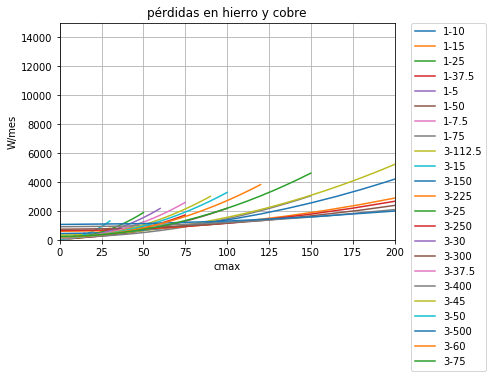

In [135]:
#perdidas totales
df = matriz.loc[:,['cmax','faca_t','pfeW','ptrW','futi_nt','capa']]
df.set_index('cmax', inplace=True)
a = df.groupby('faca_t')['ptrW'].plot(x='cmax')
plt.ylabel('W/mes')
plt.title('pérdidas en hierro y cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, 200, 0, 15000])

In [85]:
grupos = matriz.groupby(['cmax','faca_t','capa','fases','futi_nt','pfeW','pcuW','ptrW'])
bodega = pd.DataFrame(grupos['pfeW'].sum())
bodega = bodega.sort_values(['capa','fases'],ascending=[True,True])
bodega['capa'] = bodega.index.get_level_values('capa')
bodega['futi_nt'] = bodega.index.get_level_values('futi_nt')
bodega['faca_t'] = bodega.index.get_level_values('faca_t')
bodega['pcuW'] = bodega.index.get_level_values('pcuW')
bodega['ptrW'] = bodega.index.get_level_values('ptrW')
bodega['cmax'] = bodega.index.get_level_values('cmax')


#bodega = bodega.reset_index(drop=True)


#bodega

In [ ]:
df = matriz.loc[:,['pfeW','pcuW','futi_nt']]
df.set_index('futi_nt', inplace=True)
df.plot()
plt.xlabel('factor de utilización')
plt.ylabel('W/mes')
plt.title('pérdidas en hierro y cobre')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
grupos = matriz.groupby(['capa','futi_nt','pfeW'])
bodega = pd.DataFrame(grupos['pfeW'].sum())
bodega['capa'] = bodega.index.get_level_values('capa')
bodega['futi_nt'] = bodega.index.get_level_values('futi_nt')

bodega
#bodega.index.names = ['capa']

pfeW   capa  futi_nt
capa  futi_nt pfeW                                    
5.0   0.000   30.939036      30.939036    5.0    0.000
      0.200   30.939036      30.939036    5.0    0.200
      0.400   30.939036      30.939036    5.0    0.400
      0.600   30.939036      30.939036    5.0    0.600
      0.800   30.939036      30.939036    5.0    0.800
      1.000   30.939036      30.939036    5.0    1.000
      1.200   30.939036      30.939036    5.0    1.200
      1.400   30.939036      30.939036    5.0    1.400
      1.600   30.939036      30.939036    5.0    1.600
      1.800   30.939036      30.939036    5.0    1.800
      2.000   30.939036      30.939036    5.0    2.000
      2.200   30.939036      30.939036    5.0    2.200
      2.400   30.939036      30.939036    5.0    2.400
      2.600   30.939036      30.939036    5.0    2.600
      2.800   30.939036      30.939036    5.0    2.800
      3.000   30.939036      30.939036    5.0    3.000
      3.200   30.939036      30.939036    5.0    3.200
      3.400   30.939036      30.939036    5.0    3.400
      3.600   30.939036      30.939036    5.0    3.600
      3.800   30.939036      30.939036    5.0    3.800
      4.000   30.939036      30.939036    5.0    4.000
      4.200   30.939036      30.939036    5.0    4.200
      4.400   30.939036      30.939036    5.0    4.400
      4.600   30.939036      30.939036    5.0    4.600
      4.800   30.939036      30.939036    5.0    4.800
      5.000   30.939036      30.939036    5.0    5.000
      5.200   30.939036      30.939036    5.0    5.200
      5.400   30.939036      30.939036    5.0    5.400
      5.600   30.939036      30.939036    5.0    5.600
      5.800   30.939036      30.939036    5.0    5.800
...                                ...    ...      ...
500.0 0.240   1089.557983  1089.557983  500.0    0.240
      0.242   1089.557983  1089.557983  500.0    0.242
      0.244   1089.557983  1089.557983  500.0    0.244
      0.246   1089.557983  1089.557983  500.0    0.246
      0.248   1089.557983  1089.557983  500.0    0.248
      0.250   1089.557983  1089.557983  500.0    0.250
      0.252   1089.557983  1089.557983  500.0    0.252
      0.254   1089.557983  1089.557983  500.0    0.254
      0.256   1089.557983  1089.557983  500.0    0.256
      0.258   1089.557983  1089.557983  500.0    0.258
      0.260   1089.557983  1089.557983  500.0    0.260
      0.262   1089.557983  1089.557983  500.0    0.262
      0.264   1089.557983  1089.557983  500.0    0.264
      0.266   1089.557983  1089.557983  500.0    0.266
      0.268   1089.557983  1089.557983  500.0    0.268
      0.270   1089.557983  1089.557983  500.0    0.270
      0.272   1089.557983  1089.557983  500.0    0.272
      0.274   1089.557983  1089.557983  500.0    0.274
      0.276   1089.557983  1089.557983  500.0    0.276
      0.278   1089.557983  1089.557983  500.0    0.278
      0.280   1089.557983  1089.557983  500.0    0.280
      0.282   1089.557983  1089.557983  500.0    0.282
      0.284   1089.557983  1089.557983  500.0    0.284
      0.286   1089.557983  1089.557983  500.0    0.286
      0.288   1089.557983  1089.557983  500.0    0.288
      0.290   1089.557983  1089.557983  500.0    0.290
      0.292   1089.557983  1089.557983  500.0    0.292
      0.294   1089.557983  1089.557983  500.0    0.294
      0.296   1089.557983  1089.557983  500.0    0.296
      0.298   1089.557983  1089.557983  500.0    0.298

[3450 rows x 3 columns]

In [ ]:
df = matriz.loc[:,['pfeW','pcuW','futi_nt']]
df.set_index('futi_nt', inplace=True)
df.plot()
plt.xlabel('factor de utilización')
plt.ylabel('W/mes')
plt.title('pérdidas en hierro y cobre')
plt.grid(True)
plt.legend()
plt.show()